## Assignment 11

In [35]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as ss
import pandas as pd
import numpy as np
import seaborn as sns

np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges
left = 0;
right = len(xvals);
top = 0;
bottom = len(yvals);
for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    left = max(left, np.argmax(xhist>0.5))
    right = min(right, len(xvals)-np.argmax(xhist[::-1]>0.5))
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    top = max(top, np.argmax(yhist>0.5))
    bottom = min(bottom, len(yvals)-np.argmax(yhist[::-1]>0.5))

# Copy new dataset without edges
df2 = df.copy()
for z in zvals:
    df2.drop(df2.index[(df2['cx']<xvals[left]) | (df2['cx']>=xvals[right])], inplace=True)
    df2.drop(df2.index[(df2['cy']<yvals[top]) | (df2['cy']>=yvals[bottom])], inplace=True)

xvals = df2['cx'].unique()
yvals = df2['cy'].unique()
zvals = df2['cz'].unique()

df2.head()

,cx,cy,cz,unmasked,synapses,weighted
6292,448,1369,55,126357,153,238.063772
6293,448,1369,166,139932,207,290.840237
6294,448,1369,277,150269,194,253.824488
6295,448,1369,388,138071,159,226.410122
6296,448,1369,499,150842,258,336.278119


### Testing independence assumption of weighted number of synapses (between and within Z slices)

In [33]:
out = pd.pivot_table(df2, index=('cx','cy'), columns='cz', values='weighted')
print out.shape

corr = np.corrcoef(out)

(3192, 11)


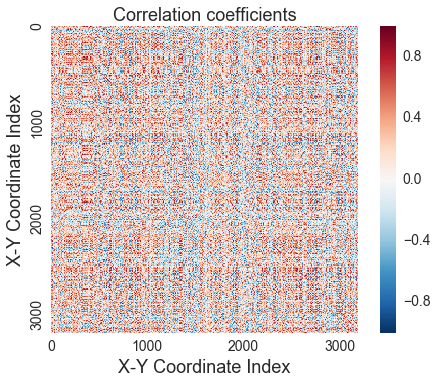

In [17]:
fs = 18
lfs = 14

plt.figure()
sns.heatmap(corr, square=True, xticklabels=1000, yticklabels=1000)
plt.xlabel('X-Y Coordinate Index', fontsize=fs)
plt.ylabel('X-Y Coordinate Index', fontsize=fs)
plt.title('Correlation coefficients', fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=lfs)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=lfs)
plt.savefig('./figs/weighted_synapses/bin_correlations.png', format='png', dpi=300)
plt.show()

In [4]:
diag = corr.diagonal() * np.eye(corr.shape[0])
hollow = corr - diag
d_det = np.linalg.det(diag)
h_det = np.linalg.det(hollow)

print "Ratio of on- and off-diagonal determinants: " + str(d_det / h_det)
print "Bins are not independent within Z slices"

Ratio of on- and off-diagonal determinants: 7.23364749953e-25
Bins are not independent within Z slices


In [5]:
corr2 = np.corrcoef(out.T)

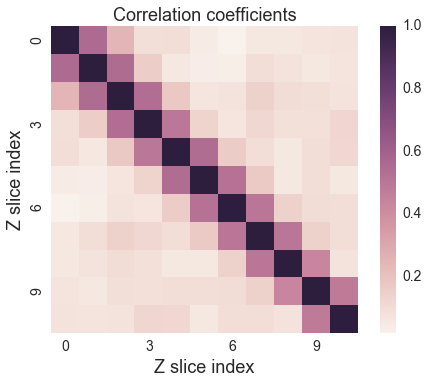

In [16]:
fs = 18
lfs = 14

plt.figure()
sns.heatmap(corr2, square=True, xticklabels=3, yticklabels=3)
plt.xlabel('Z slice index', fontsize=fs)
plt.ylabel('Z slice index', fontsize=fs)
plt.title('Correlation coefficients', fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=lfs)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=lfs)
plt.savefig('./figs/weighted_synapses/Z_correlations.png', format='png', dpi=300)
plt.show()

In [7]:
diag2 = corr2.diagonal() * np.eye(corr2.shape[0])
hollow2 = corr2 - diag2
d_det = np.linalg.det(diag2)
h_det = np.linalg.det(hollow2)

print "Ratio of on- and off-diagonal determinants: " + str(d_det / h_det)
print "Bins are independent between Z slices"

Ratio of on- and off-diagonal determinants: 3786.08104973
Bins are independent between Z slices


### Testing identical distribution assumption of weighted number of synapses

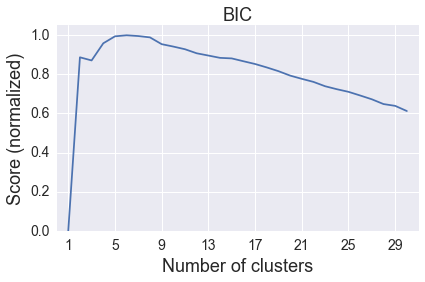

Optimal number of clusters is 6


In [37]:
import sklearn.mixture

out = df2['weighted'].reshape(-1,1)
nclusters = np.arange(1,31)

bic = np.array(())
for idx in nclusters:
    print "Fitting and evaluating model with " + str(idx) + " clusters."
    gmm = sklearn.mixture.GMM(n_components=idx, n_iter=1000, covariance_type = 'diag')
    gmm.fit(out)
    bic = np.append(bic, gmm.bic(out))

score = 1.0/bic
score = score - np.min(score)
score = score / np.max(score)

fs = 18
lfs = 14

sns.set_style('darkgrid')

plt.figure()
plt.plot(nclusters, score)
plt.title('BIC', fontsize=fs)
plt.ylabel('Score (normalized)', fontsize=fs)
plt.xlabel('Number of clusters', fontsize=fs)
plt.gca().set_xlim([0,31])
plt.gca().set_ylim([0,1.05])
plt.gca().set_xticks(nclusters[::4])
plt.tick_params(axis='both', which='major', labelsize=lfs)
plt.tight_layout()
plt.savefig('./figs/weighted_synapses/BIC.png', format='png', dpi=300)
plt.show()


optn = nclusters[np.argmin(bic)]
print "Optimal number of clusters is", optn

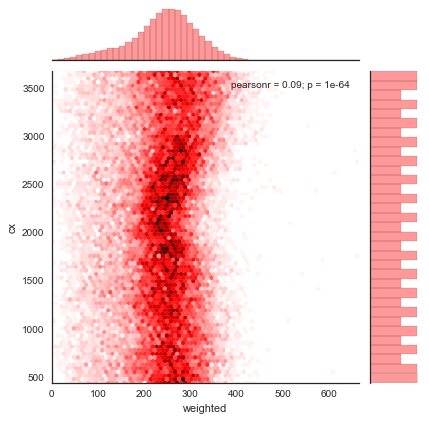

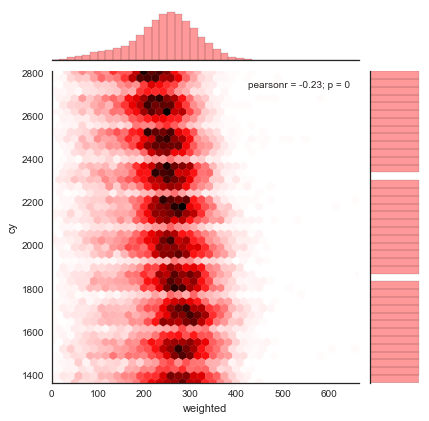

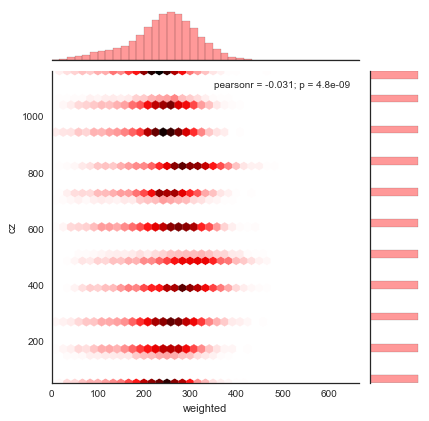

In [8]:
with sns.axes_style('white'):
    sns.jointplot(x='weighted', y='cx', data = df2,kind='hex', color='r'); 
#                   xlim=(np.min(grid_means)-0.02*np.ptp(grid_means),np.max(grid_means)+0.02*np.ptp(grid_means))  , 
#                   ylim=(np.min(grid_x)-0.02*np.ptp(grid_x),np.max(grid_x)+0.02*np.ptp(grid_x)),
#                   joint_kws={'gridsize':40}, marginal_kws={'bins':40}, stat_func=None);

with sns.axes_style('white'):
    sns.jointplot(x='weighted', y='cy', data = df2,kind='hex', color='r',joint_kws={'gridsize':40},marginal_kws={'bins':40}); 

with sns.axes_style('white'):
    sns.jointplot(x='weighted', y='cz', data = df2,kind='hex', color='r',joint_kws={'gridsize':40},marginal_kws={'bins':40}); 

-trend in y direction
-no trend in x and z direction

### K-means clustering based on optimal number of clusters

In [19]:
from sklearn.cluster import KMeans

est = KMeans(n_clusters = optn)
est.fit(df2['weighted'].reshape(-1,1))
labels = est.labels_
df2['label'] = labels

df2.head()

,cx,cy,cz,unmasked,synapses,weighted,label
6292,448,1369,55,126357,153,238.063772,0
6293,448,1369,166,139932,207,290.840237,5
6294,448,1369,277,150269,194,253.824488,0
6295,448,1369,388,138071,159,226.410122,2
6296,448,1369,499,150842,258,336.278119,5


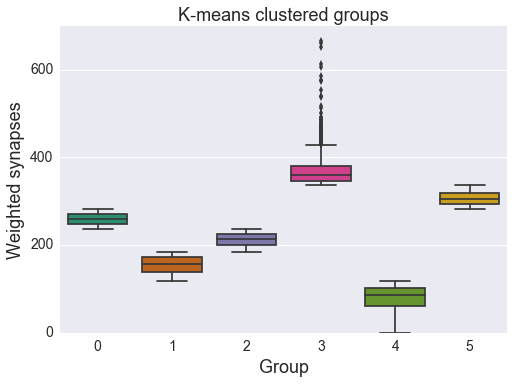

In [20]:
fs = 18
tfs = 14

plt.figure()
sns.boxplot(x='label', y='weighted', data=df2, palette='Dark2')
plt.yticks(np.arange(0,700,200))
plt.xlabel('Group', fontsize=fs)
plt.ylabel('Weighted synapses', fontsize=fs)
plt.title('K-means clustered groups', fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.show()

In [21]:
# Sort groups by means
groups = np.sort(df2['label'].unique())

means = np.array([df2.loc[df2['label']==label,'weighted'].mean() for label in groups])
print means
reindex = np.argsort(means)
print reindex

new_labels = np.array(labels)

for label in groups:
    new_labels[labels==label] = np.argmax(reindex==label)

df2['label'] = new_labels

means = np.array([df2.loc[df2['label']==label,'weighted'].mean() for label in groups])

df2.head()

[ 259.69842034  155.17545993  213.38507133  368.29115258   80.20085416
  306.70974311]
[4 1 2 0 5 3]


,cx,cy,cz,unmasked,synapses,weighted,label
6292,448,1369,55,126357,153,238.063772,3
6293,448,1369,166,139932,207,290.840237,4
6294,448,1369,277,150269,194,253.824488,3
6295,448,1369,388,138071,159,226.410122,2
6296,448,1369,499,150842,258,336.278119,4


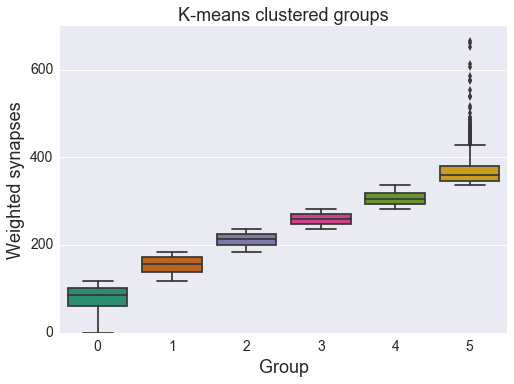

In [22]:
fs = 18
tfs = 14

plt.figure()
sns.boxplot(x='label', y='weighted', data=df2, palette='Dark2')
plt.yticks(np.arange(0,700,200))
plt.xlabel('Group', fontsize=fs)
plt.ylabel('Weighted synapses', fontsize=fs)
plt.title('K-means clustered groups', fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.savefig('./figs/weighted_synapses/K-means_group_boxplots.png', format='png', dpi=300)
plt.show()

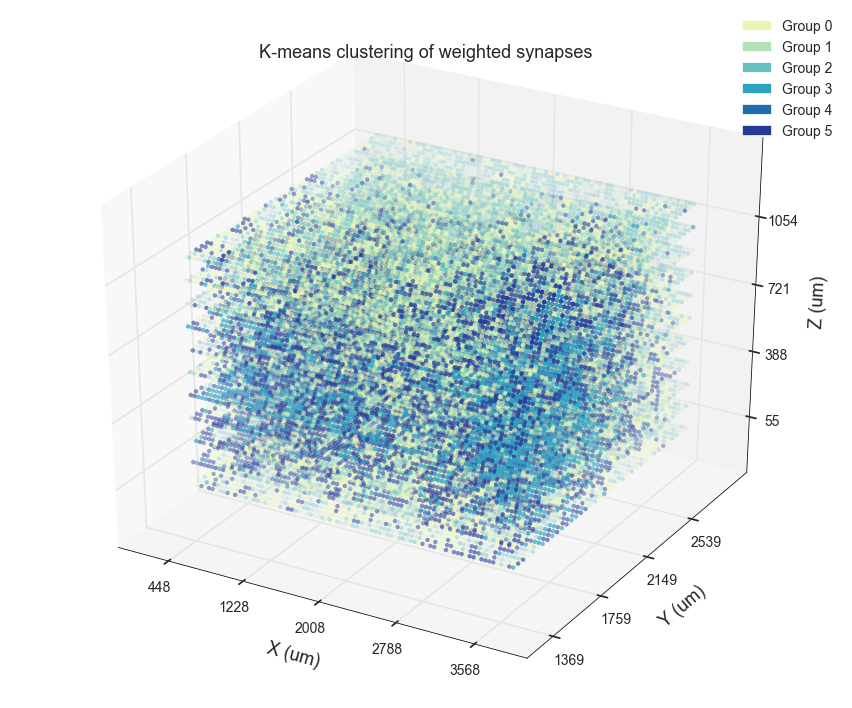

In [29]:
import matplotlib.patches as mpatches

sns.set_style('white')

fs = 18
tfs = 14

wt_max = 400 #df2['weighted'].max()
wt_min = df2['weighted'].min()
cmap = np.array(sns.color_palette('YlGnBu'))
colors = [np.append(cmap[label], np.min((1,(wt-wt_min)/(wt_max-wt_min)))) for label, wt in zip(labels, df2['weighted'])]

ax = plt.figure(figsize=(12,10)).gca(projection='3d')
ax.scatter(xs=df2['cx'], ys=df2['cy'], zs=df2['cz'], 
                     s=20, c=colors,
                     edgecolors=[0,0,0,0])
plt.xticks(df2['cx'].unique()[::20], fontsize=tfs)
plt.yticks(df2['cy'].unique()[::10], fontsize=tfs)
ax.zaxis.set_ticks(df2['cz'].unique()[::3])
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X (um)', fontsize=fs, labelpad=20)
plt.ylabel('Y (um)', fontsize=fs, labelpad=20)
plt.gca().set_zlabel('Z (um)', fontsize=fs, labelpad=20)
plt.title('K-means clustering of weighted synapses', fontsize=fs)
plt.tight_layout()

patches = [mpatches.Patch(color=cmap[group], label='Group '+str(group)) for group in groups]
plt.legend(handles=patches, fontsize=tfs)

plt.savefig('./figs/weighted_synapses/K-means_group_all.png', format='png', dpi=300)
plt.show()

K-means clustering of weighted synapses


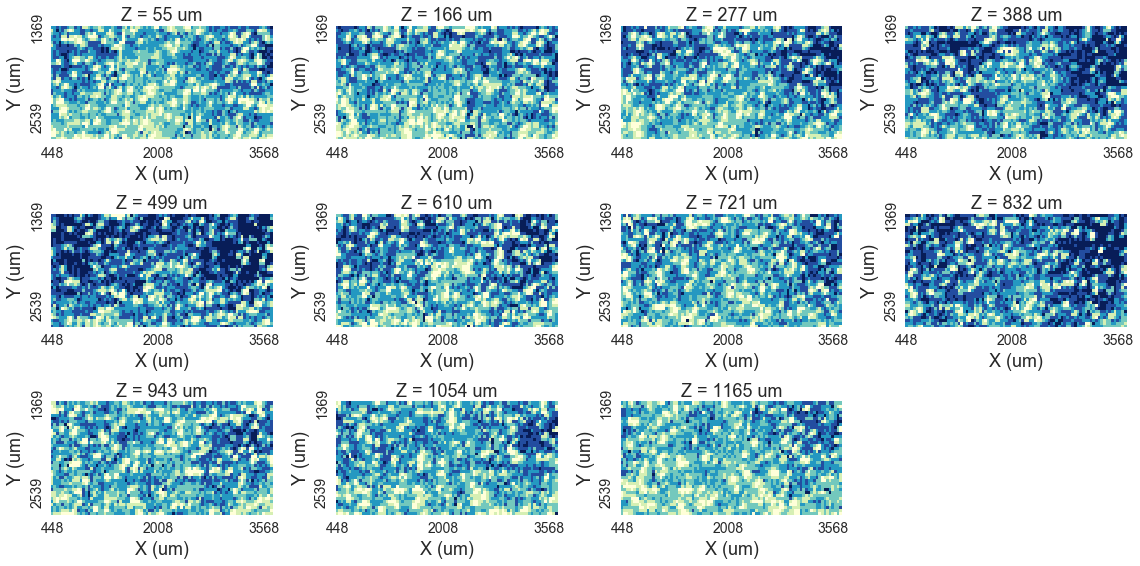

In [14]:
fs = 18
tfs = 14

plt.figure(figsize=(16,8))
print "K-means clustering of weighted synapses"
for zi, z in enumerate(zvals):
    XY = pd.pivot_table(df2[df2['cz']==z], index='cy', columns='cx', values='label')
    plt.subplot(3,4,1+zi)
    sns.heatmap(XY, xticklabels=40, yticklabels=30, 
                vmin=0, vmax=5, cbar=False, cmap=cm.get_cmap('YlGnBu', lut=optn))
    plt.gca().set_title('Z = '+str(z)+' um', fontsize=fs)
    plt.gca().set_xlabel('X (um)', fontsize=fs)
    plt.gca().set_ylabel('Y (um)', fontsize=fs)
    plt.tick_params(axis='both', which='major', labelsize=tfs)

plt.tight_layout()
plt.show()

### Correlation between weighted synapses and Z layers

Entropy with disk = 15


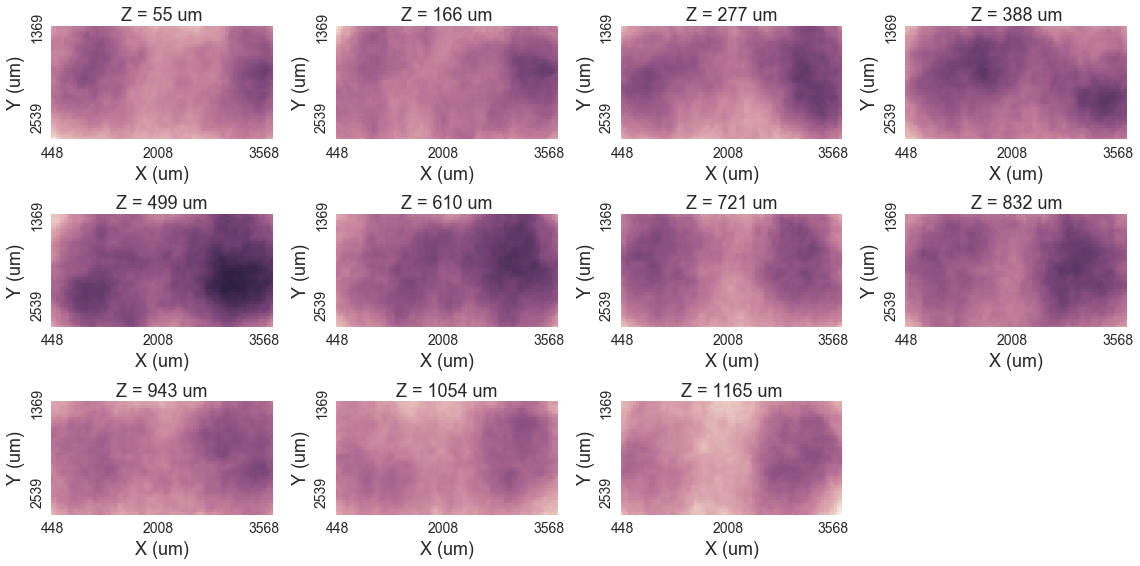

In [15]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

wt_max = df2['weighted'].max()

S = np.array([
        pd.pivot_table(df2[df2['cx']==x], index='cy', columns='cz', values='weighted', aggfunc=np.sum).values 
        for x in xvals
    ])

d = 15 # disk size

print 'Entropy with disk =', d
df_list = []
vmin = float('inf')
vmax = -float('inf')
for zi, z in enumerate(zvals):
    imXY = np.rint(255*(S[:,:,zi].T/wt_max)).astype(np.uint8)
    
    tmpdf = pd.melt(pd.DataFrame(entropy(imXY, disk(d)), index=yvals, columns=xvals))
    tmpdf.columns = ['cx', 'entropy']
    tmpdf['cy'] = np.tile(yvals, len(xvals))
    tmpdf['cz'] = z
    
    df_list.append(tmpdf)
    
    vmin = np.min([vmin, np.min(df_list[-1]['entropy'].values.ravel())])
    vmax = np.max([vmax, np.max(df_list[-1]['entropy'].values.ravel())])

entdf = pd.concat(df_list)

plt.figure(figsize=(16,8))
for zi, z in enumerate(zvals):
    entXY = pd.pivot_table(entdf[entdf['cz']==z], index='cy', columns='cx', values='entropy')
    
    plt.subplot(3,4,1+zi)
    sns.heatmap(entXY, xticklabels=40, yticklabels=30, vmin=vmin, vmax=vmax, cbar=False)
    plt.gca().set_title('Z = '+str(z)+' um', fontsize=fs)
    plt.gca().set_xlabel('X (um)', fontsize=fs)
    plt.gca().set_ylabel('Y (um)', fontsize=fs)
    plt.tick_params(axis='both', which='major', labelsize=tfs)

plt.tight_layout()
plt.show()

In [16]:
df2 = df2.merge(entdf, on=['cx','cy','cz'])
df2.head()

,cx,cy,cz,unmasked,synapses,weighted,label,entropy
0,448,1369,55,126357,153,238.063772,3,6.161584
1,448,1369,166,139932,207,290.840237,4,5.897542
2,448,1369,277,150269,194,253.824488,3,6.026833
3,448,1369,388,138071,159,226.410122,2,6.085818
4,448,1369,499,150842,258,336.278119,4,6.007779


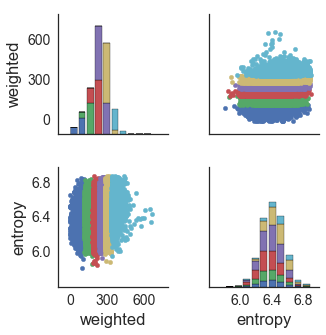

There doesn't appear to be any correlation


In [19]:
from matplotlib import ticker

with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.PairGrid(df2, hue='label', vars=['weighted', 'entropy'])
    g = g.map_diag(plt.hist)
    g = g.map_offdiag(plt.scatter)

    for ax in g.axes.flat:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4, prune="both"))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(4, prune="both"))

        ax.tick_params(axis='both', which='major', labelsize=tfs)
        
    plt.show()

print "There doesn't appear to be any correlation"